<a href="https://colab.research.google.com/github/marcelogarret/rna/blob/main/aula10a_forecasting_garret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-05-06 22:34:54--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-05-06 22:34:54 (42.8 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



**Dataset Passageiros de Companhias Aéreas**

Registra o número mensal em milhares de passageiros de companhias aéreas dos EUA de 1949 a 1960. É uma série temporal clássica que é geralmente usada para testar métodos de previsão de séries temporais

**Parâmetros do Dataset**

1.   **sequence_length**:  são utilizados 12 meses (1 ano) de dados para prever o número de passageiros no próximo mês. Isso permite capturar a sazonalidade anual, uma característica importante deste dataset.
2.   **sampling_rate**: Cada registro mensal será considerado, sem pular meses, para preservar a continuidade sazonal.
3.   **delay**: A previsão será feita para o mês subsequente, adequada para planejamento e alocação de recursos.

In [2]:
import numpy as np

raw_data = []
with open("airline-passengers.csv") as f:
    f.readline()  # Pula o cabeçalho
    for line in f:
        fields = line.split(',')
        raw_data.append(float(fields[1]))  # Assume que a segunda coluna é o número de passageiros

raw_data = np.array(raw_data)
print("Número total de pontos:", len(raw_data))

Número total de pontos: 144


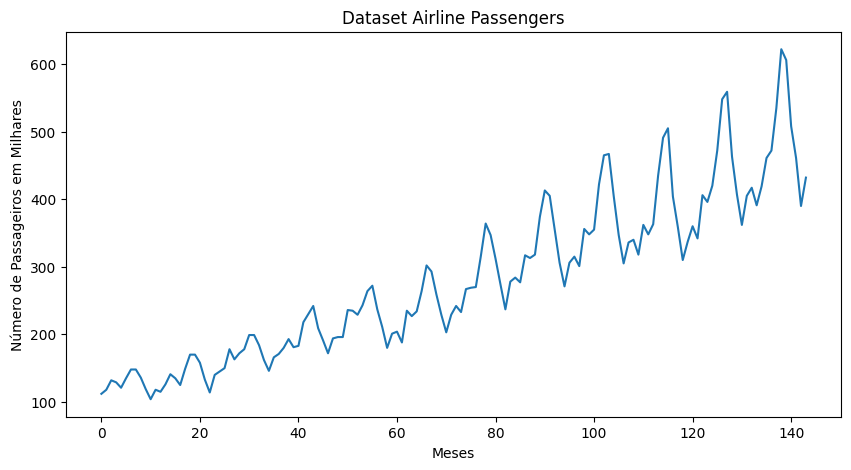

In [3]:
from matplotlib import pyplot as plt

# Gráfico para visualizar dados
plt.figure(figsize=(10, 5))
plt.plot(range(len(raw_data)), raw_data)
plt.title("Dataset Airline Passengers")
plt.xlabel("Meses")
plt.ylabel("Número de Passageiros em Milhares")
plt.show()

In [4]:
num_train_samples = int(0.75 * len(raw_data))
num_val_samples = int(0.125 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
(num_train_samples, num_val_samples, num_test_samples)

(108, 18, 18)

In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [6]:
train_data = raw_data[:num_train_samples]
val_data = raw_data[num_train_samples:num_train_samples + num_val_samples]
test_data = raw_data[num_train_samples + num_val_samples:]

In [7]:
from tensorflow import keras

# Parâmetros para a criação do dataset
sequence_length = 12  # 12 meses para previsão
sampling_rate = 1     # Cada mês é considerado
delay = 1             # Previsão para o próximo mês

train_dataset = keras.utils.timeseries_dataset_from_array(
    train_data[:-delay],
    targets=train_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=32,
    shuffle=True
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    val_data[:-delay],
    targets=val_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=32,
    shuffle=True
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    test_data[:-delay],
    targets=test_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=32,
    shuffle=True
)

In [8]:
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break

samples shape (32, 12)
targets shape (32,)


#baseline

In [9]:
# Avaliação ingênua (Naive)
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1] # A última observação é usada como previsão
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 0.35
Test MAE: 1.20


#densely conected

In [10]:
from tensorflow.keras import layers

# Dado que estamos tratando de uma série univariada, `raw_data.shape[-1]` é 1
# Configurando o modelo de rede neural
inputs = keras.Input(shape=(sequence_length, 1))  # Modificado para refletir a única série de entrada
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Callback para salvar o modelo com o melhor desempenho baseado no conjunto de validação
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_dense.keras",
                                    save_best_only=True)
]

# Compilação do modelo com otimizador RMSprop, função de perda MSE e acompanhamento do MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_dense.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
3/3 [==============================] - 3s 116ms/step - loss: 1.6768 - mae: 1.0420 - val_loss: 1.9980 - val_mae: 1.2640
Epoch 2/10
3/3 [==============================] - 0s 34ms/step - loss: 0.9407 - mae: 0.7689 - val_loss: 1.1023 - val_mae: 0.8448
Epoch 3/10
3/3 [==============================] - 0s 34ms/step - loss: 0.6042 - mae: 0.6135 - val_loss: 0.7104 - val_mae: 0.5765
Epoch 4/10
3/3 [==============================] - 0s 50ms/step - loss: 0.4036 - mae: 0.5088 - val_loss: 0.5238 - val_mae: 0.4638
Epoch 5/10
3/3 [==============================] - 0s 35ms/step - loss: 0.2743 - mae: 0.4297 - val_loss: 0.4131 - val_mae: 0.4555
Epoch 6/10
3/3 [==============================] - 0s 32ms/step - loss: 0.1915 - mae: 0.3679 - val_loss: 0.3549 - val_mae: 0.4433
Epoch 7/10
3/3 [==============================] - 0s 32ms/step - loss: 0.1377 - mae: 0.3145 - val_loss: 0.3110 - val_mae: 0.4325
Epoch 8/10
3/3 [==============================] - 0s 34ms/step - loss: 0.1056 - mae: 0.2754 - va

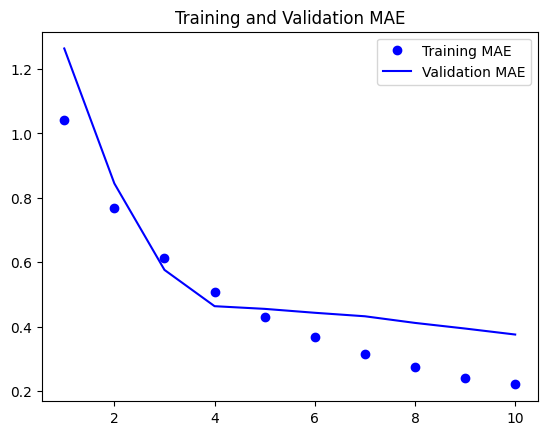

In [11]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

#1D convolutional model

In [12]:
# Ajustando o modelo para evitar a redução excessiva de dimensionalidade
inputs = keras.Input(shape=(sequence_length, 1))  # A entrada ainda espera uma única série temporal por amostra
x = layers.Conv1D(16, 24, activation="relu", padding='same')(inputs)  # Aplicando um Conv1D com 8 filtros de tamanho 24
x = layers.MaxPooling1D(2)(x)  # Aplicando apenas um pooling para reduzir a dimensionalidade
x = layers.Conv1D(16, 8, activation="relu", padding='same')(x)  # Aplicando outro Conv1D com 8 filtros de tamanho 12
x = layers.MaxPooling1D(2)(x) # Aplicando apenas um pooling para reduzir a dimensionalidade
x = layers.Conv1D(16, 3, activation="relu", padding='same')(x)  # Mantendo as dimensões com padding 'same'
x = layers.GlobalAveragePooling1D()(x)  # Global average pooling para resumir as características
outputs = layers.Dense(1)(x)  # Camada de saída
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo baseado no desempenho de validação
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_conv_adjusted.keras",
                                    save_best_only=True)
]

# Compilação do modelo
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_conv_adjusted.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
3/3 [==============================] - 3s 174ms/step - loss: 0.6333 - mae: 0.6618 - val_loss: 1.7700 - val_mae: 1.1565
Epoch 2/10
3/3 [==============================] - 0s 37ms/step - loss: 0.4448 - mae: 0.5549 - val_loss: 1.2479 - val_mae: 0.9054
Epoch 3/10
3/3 [==============================] - 0s 37ms/step - loss: 0.3201 - mae: 0.4675 - val_loss: 0.9940 - val_mae: 0.7648
Epoch 4/10
3/3 [==============================] - 0s 37ms/step - loss: 0.2294 - mae: 0.3919 - val_loss: 0.8162 - val_mae: 0.6780
Epoch 5/10
3/3 [==============================] - 0s 39ms/step - loss: 0.1608 - mae: 0.3247 - val_loss: 0.6207 - val_mae: 0.5754
Epoch 6/10
3/3 [==============================] - 0s 36ms/step - loss: 0.1202 - mae: 0.2744 - val_loss: 0.5506 - val_mae: 0.5402
Epoch 7/10
3/3 [==============================] - 0s 35ms/step - loss: 0.1054 - mae: 0.2471 - val_loss: 0.4191 - val_mae: 0.4400
Epoch 8/10
3/3 [==============================] - 0s 38ms/step - loss: 0.0875 - mae: 0.2189 - va

#Rede Recorrente


In [13]:
# Definindo o modelo LSTM para a previsão de séries temporais
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.LSTM(64)(inputs)  # Usando uma camada LSTM com 32 unidades
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm.keras",  # Nome alterado para refletir o novo dataset
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e o métrico MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
3/3 [==============================] - 3s 228ms/step - loss: 0.4174 - mae: 0.5229 - val_loss: 1.4785 - val_mae: 1.0012
Epoch 2/10
3/3 [==============================] - 0s 62ms/step - loss: 0.1945 - mae: 0.3361 - val_loss: 1.0648 - val_mae: 0.7822
Epoch 3/10
3/3 [==============================] - 0s 60ms/step - loss: 0.1458 - mae: 0.2883 - val_loss: 0.8181 - val_mae: 0.6613
Epoch 4/10
3/3 [==============================] - 0s 44ms/step - loss: 0.1339 - mae: 0.2835 - val_loss: 0.7058 - val_mae: 0.5929
Epoch 5/10
3/3 [==============================] - 0s 48ms/step - loss: 0.1288 - mae: 0.2789 - val_loss: 0.6549 - val_mae: 0.5584
Epoch 6/10
3/3 [==============================] - 0s 50ms/step - loss: 0.1268 - mae: 0.2744 - val_loss: 0.5735 - val_mae: 0.5230
Epoch 7/10
3/3 [==============================] - 0s 43ms/step - loss: 0.1215 - mae: 0.2784 - val_loss: 0.7611 - val_mae: 0.6294
Epoch 8/10
3/3 [==============================] - 0s 49ms/step - loss: 0.1214 - mae: 0.2651 - va

# dropout-regularized LSTM

In [14]:
# Definindo o modelo LSTM com dropout para prevenção de overfitting
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.LSTM(64)(inputs)  # Usando LSTM com 64 unidades, sem dropout recorrente
x = layers.Dropout(0.5)(x)  # Dropout após a camada LSTM para reduzir ainda mais o overfitting
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm_dropout.keras",  # Nome do arquivo de modelo atualizado
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e a métrica MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm_dropout.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
3/3 [==============================] - 3s 225ms/step - loss: 1.1759 - mae: 0.8931 - val_loss: 4.0889 - val_mae: 1.8916
Epoch 2/10
3/3 [==============================] - 0s 33ms/step - loss: 0.6941 - mae: 0.6859 - val_loss: 2.8538 - val_mae: 1.5311
Epoch 3/10
3/3 [==============================] - 0s 31ms/step - loss: 0.4748 - mae: 0.5582 - val_loss: 1.9603 - val_mae: 1.2069
Epoch 4/10
3/3 [==============================] - 0s 33ms/step - loss: 0.2809 - mae: 0.4095 - val_loss: 1.3543 - val_mae: 0.9268
Epoch 5/10
3/3 [==============================] - 0s 36ms/step - loss: 0.2177 - mae: 0.3452 - val_loss: 0.9683 - val_mae: 0.7285
Epoch 6/10
3/3 [==============================] - 0s 32ms/step - loss: 0.1739 - mae: 0.3276 - val_loss: 0.7292 - val_mae: 0.5965
Epoch 7/10
3/3 [==============================] - 0s 20ms/step - loss: 0.1718 - mae: 0.3266 - val_loss: 0.7351 - val_mae: 0.6009
Epoch 8/10
3/3 [==============================] - 0s 21ms/step - loss: 0.1565 - mae: 0.3207 - va

#bidirectional LSTM

In [15]:
# Definindo o modelo LSTM Bidirecional para a previsão de séries temporais
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.Bidirectional(layers.LSTM(64))(inputs)  # LSTM bidirecional com 64 unidades em cada direção
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm_bidirectional.keras",  # Nome do arquivo de modelo atualizado
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e a métrica MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm_bidirectional.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
3/3 [==============================] - 5s 781ms/step - loss: 0.3921 - mae: 0.5128 - val_loss: 1.0879 - val_mae: 0.7947
Epoch 2/10
3/3 [==============================] - 0s 40ms/step - loss: 0.1622 - mae: 0.3100 - val_loss: 0.7305 - val_mae: 0.6133
Epoch 3/10
3/3 [==============================] - 0s 36ms/step - loss: 0.1358 - mae: 0.2865 - val_loss: 0.6538 - val_mae: 0.5635
Epoch 4/10
3/3 [==============================] - 0s 41ms/step - loss: 0.1287 - mae: 0.2783 - val_loss: 0.5805 - val_mae: 0.5229
Epoch 5/10
3/3 [==============================] - 0s 41ms/step - loss: 0.1257 - mae: 0.2758 - val_loss: 0.5622 - val_mae: 0.5143
Epoch 6/10
3/3 [==============================] - 0s 23ms/step - loss: 0.1167 - mae: 0.2689 - val_loss: 0.6713 - val_mae: 0.5844
Epoch 7/10
3/3 [==============================] - 0s 42ms/step - loss: 0.1125 - mae: 0.2642 - val_loss: 0.6176 - val_mae: 0.5511
Epoch 8/10
3/3 [==============================] - 0s 22ms/step - loss: 0.1104 - mae: 0.2561 - va